In [1]:
import random
seed_val = 1000
random.seed(seed_val)
import numpy as np
np.random.seed(seed_val)
import tensorflow as tf
tf.set_random_seed(seed_val)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, TimeDistributed
from keras.layers import Concatenate, Flatten
from keras.layers import GRU, Conv2D, MaxPooling2D
from keras.layers import Input, Reshape, Dot, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import regularizers
from keras.utils.vis_utils import plot_model
import keras
import keras.backend as K
from data_handle import *
from gensim_wrapper import *
from utils import *
import gensim
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

c:\users\amany\appdata\local\conda\conda\envs\gputf3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\amany\appdata\local\conda\conda\envs\gputf3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def conv_model_multi(n_chars, word_length, n_units):
    root_word_input = Input(shape=(word_length, n_chars, 1), name="root_word_input")
    
    x = Conv2D(16, (5, 5), padding='same', activation='relu')(root_word_input)
    x = MaxPooling2D(3, 3)(x)

    x = Flatten()(x)

    state_h = Dense(n_units, activation='linear')(x)
    
    consonant_decoder_inputs = Input(shape=(None, n_chars), name="target_consonant")
    consonant_decoder_gru = GRU(n_units, return_sequences=True, return_state=True,  name="consonant_decoder_gru")
    consonant_decoder_outputs, _= consonant_decoder_gru(consonant_decoder_inputs, initial_state=state_h)

    consonant_decoder_dense = Dense(n_chars, activation='softmax', name="consonant_output")
    consonant_decoder_outputs = consonant_decoder_dense(consonant_decoder_outputs)

    main_model = Model([root_word_input, consonant_decoder_inputs], consonant_decoder_outputs)
    
    encoder_model = Model(root_word_input, state_h)
    
    decoder_state_input_h = Input(shape=(n_units,))
    
    consonant_decoder_outputs, state_h= consonant_decoder_gru(consonant_decoder_inputs, initial_state=decoder_state_input_h)
    consonant_decoder_outputs = consonant_decoder_dense(consonant_decoder_outputs)
    
    decoder_model = Model([consonant_decoder_inputs, decoder_state_input_h], consonant_decoder_outputs)

    return main_model, encoder_model, decoder_model

def pred_embeddings_multi(vocab, encoder, int2word, char2int,embed_size, n_chars, word_width):
    embeddings = np.ndarray((len(vocab), embed_size))
    i = 0
    buffer = []
    buffer_size = 10000
    for wi, word in enumerate(vocab):
        word = int2word[word2int[word]]
        word_mat = word2mat(char2int,word, max_char_length=n_chars, max_word_length=word_width)
        buffer.append(word_mat)
        if len(buffer) == buffer_size or len(vocab) - wi < buffer_size:
            buffer_np = np.stack(buffer).reshape((-1, word_width, n_chars, 1))
            result = encoder.predict(buffer_np)
            embeddings[i:i+len(buffer)] = result
            i += len(buffer)
            buffer = []
            if i % (4 *buffer_size) == 0:
                print("Predicting: {0:.2f}%".format((i * 100.0 / len(vocab))))
    print("finished")
    return embeddings


In [3]:
text = open('data/news_en.txt', encoding='utf-8').read()
chars = sorted(list(set(text)) + ['(', ')'])

In [4]:
words = text.split(' ')
vocab, word2int, int2word = build_vocab(words)
vocab = list(sorted(set(words)))

In [5]:
# m = 0
# for v in vocab:
#     if len(v) > m:
#         m = len(v)
#         print(v)
# print(m)

In [6]:
char2int = {c : i for i, c in enumerate(chars)}
int2char = {i : c for i, c in enumerate(chars)}

In [7]:
def char2vec(char2int, char, max_length):
    vec = np.zeros((max_length, ))
    vec[char2int[char]] = 1
    return vec

def word2mat(char2int, word, max_char_length, max_word_length):
    mat = np.zeros((max_word_length, max_char_length))
    for i in range(len(word)):
        c = char2int[word[i]]
        mat[i, c] = 1
    space_c = char2int[' ']
    mat[len(word):, space_c] = 1
    return mat


def generate_single(words, char2int, batch_size):
    """

    returns cbow input of integer sequence of words. the inputs are for RNN where the context, is normal
    but for the decoder, there is an input and output

    """
    targets, target_inputs = [], []
    for word in words:
        target = word  
        target_input = '(' + target + ')'
        targets.append(target)
        target_inputs.append(target_input)
    batch = 0
    n_batchs = len(words) // batch_size
    n_chars = len(char2int)
    max_word_width = 24
    while True:
        batch_targets = targets[batch:batch + batch_size]
        batch_target_ins = target_inputs[batch:batch + batch_size]
        batch_words = words[batch:batch + batch_size]

        batch_inputs = np.ndarray(
            (batch_size, max_word_width, n_chars), dtype=np.float32)
        batch_dec_inputs = np.ndarray(
            (batch_size, max_word_width, n_chars), dtype=np.float32)
        batch_output = np.ndarray(
            (batch_size, max_word_width, n_chars), dtype=np.float32)
        for i in range(batch_size):
            batch_inputs[i] = word2mat(char2int,batch_words[i], max_char_length=n_chars, max_word_length=max_word_width)
            batch_output[i] = word2mat(char2int,batch_targets[i], max_char_length=n_chars, max_word_length=max_word_width)
            batch_dec_inputs[i] = word2mat(char2int,batch_target_ins[i], max_char_length=n_chars, max_word_length=max_word_width)
        
        batch_inputs = batch_inputs.reshape((-1, max_word_width, n_chars, 1))
        yield [batch_inputs, batch_dec_inputs], batch_output
        batch += 1
        if batch == n_batchs:
            batch = 0


In [8]:
batch_size = 300
embed_size = 100
max_word_width = 24
n_chars = len(char2int)
n_batchs = len(vocab) // batch_size
gen = generate_single(words, char2int, batch_size=batch_size)
# [x1, x2], y = next(gen)

In [18]:
try:
    del multi_train
    del multi_enc
    del multi_dec
    keras.backend.clear_session()
    gc.collect()
except:
    pass
multi_train, multi_enc, multi_dec = conv_model_multi(n_chars, max_word_width, embed_size)
adam = keras.optimizers.Nadam(.001)
multi_train.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
# multi_gen = generate_word_images_multi(words, char2tup, batch_size, n_consonant, n_vowel)
# plot_model(multi_train)
# multi_train.summary()

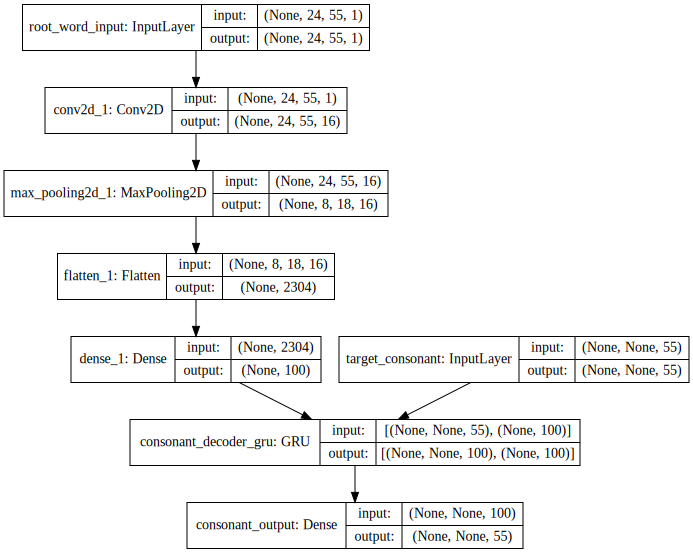

In [19]:
SVG(model_to_dot(multi_train, show_shapes=True).create(prog='dot', format='svg'))

In [20]:
history = multi_train.fit_generator(gen, steps_per_epoch=n_batchs, epochs = 5)

Epoch 1/5
967/967 [==============================] - 83s 86ms/step - loss: 0.3440 - acc: 0.9142 1s - loss: 0.3479 
Epoch 2/5
967/967 [==============================] - 82s 85ms/step - loss: 0.0808 - acc: 0.9901
Epoch 3/5
967/967 [==============================] - 83s 85ms/step - loss: 0.0272 - acc: 0.9963
Epoch 4/5
967/967 [==============================] - 83s 85ms/step - loss: 0.0075 - acc: 0.9993 3s - loss: 0.0077 - acc - ETA:
Epoch 5/5
967/967 [==============================] - 83s 86ms/step - loss: 0.0115 - acc: 0.9984 0s - loss: 0.0115 - acc: 0.


In [21]:
embeddings = pred_embeddings_multi(vocab, multi_enc,int2word, char2int, embed_size, n_chars, max_word_width)

Predicting: 13.79%
Predicting: 27.57%
Predicting: 41.36%
Predicting: 55.15%
Predicting: 68.93%
Predicting: 82.72%
Predicting: 96.51%
finished


In [22]:
file = open("results/spliteden.txt", encoding='utf8', mode='w')
file.write("{0} {1}\n".format(len(word2int), embed_size))
for word, index in word2int.items():
    e = embeddings[index]
    e = ' '.join(map(lambda x: str(x), e))
    file.write("{0} {1}\n".format(word, e))
file.close()
